# CAICT 風機結冰預測 - Baseline

2017/07/23  
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

### Summary

### Outline

## 1. Load Data and Modules

**Load Python modules:**

In [46]:
import pandas as pd
import os
import sys
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import shutil
import matplotlib.pyplot as plt
import shutil
import csv
import sklearn as sk
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import precision_score
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from collections import OrderedDict

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
import xgboost as xgb
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

%matplotlib inline
pd.set_option('display.max_columns', None)
#InteractiveShell.ast_node_interactivity = "all"

** utils **

In [47]:
def variable_summaries(var, name):  
    with tf.name_scope('summaries_'+str(name)):  
        mean = tf.reduce_mean(var)  
        tf.summary.scalar('mean', mean)  
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))  
        tf.summary.scalar('stddev', stddev)  
        tf.summary.scalar('max', tf.reduce_max(var))  
        tf.summary.scalar('min', tf.reduce_min(var))  
        tf.summary.histogram('histogram', var)  
        
def updateProgress(msg):
    sys.stdout.write('\r')
    sys.stdout.write(msg)
    sys.stdout.flush()

** load data**

In [76]:
def variable_selection(data, isTest=False):
    if isTest:
        fixed_variable = ['time','group']
    else:
        fixed_variable = ['label','event','time','group','timestamp']
    #selected_variable = ['pitch1_angle','pitch2_angle','pitch3_angle','pitch1_speed','pitch3_speed','pitch2_speed']
    selected_variable = ['pitch1_angle','pitch2_angle','pitch3_angle','pitch1_speed','pitch3_speed','pitch2_speed','power','yaw_position','environment_tmp']
    variable = selected_variable + fixed_variable 
    data = data[variable]
    return data

def load_resample_data(id, remove_unknown=True, split_case=20, split_validation=True, policy=1, varsel=False, label=None):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=id,POLICY=policy)
    data_resample = pd.read_csv(filename)
    if varsel:
        data_resample=variable_selection(data_resample)
    
    if remove_unknown:
        data_resample = data_resample[data_resample['label']!=2]
    
    if label is not None:
        data_resample = data_resample[data_resample['label']==label]
    
    data_resample_train = data_resample[data_resample['event']<split_case]
    data_resample_valid = data_resample[data_resample['event']>=split_case]

    train_aX = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    train_ay = data_resample['label']
    train_aY = np.eye(2)[train_ay.values.astype(int)]
    
    train_X = data_resample_train.drop(['label','time','group','timestamp','event'], axis=1)
    train_y = data_resample_train['label']
    valid_X = data_resample_valid.drop(['label','time','group','timestamp','event'], axis=1)
    valid_y = data_resample_valid['label']
    train_Y = np.eye(2)[train_y.values.astype(int)]
    valid_Y = np.eye(2)[valid_y.values.astype(int)]

    train_abnormal = data_resample_train[data_resample_train['label']==1]
    train_normal = data_resample_train[data_resample_train['label']==0]
    train_desc = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(train_normal), j=len(train_normal)/len(data_resample_train),k=len(train_abnormal),m=len(train_abnormal)/len(data_resample_train), n=len(data_resample_train))
    
    valid_abnormal = data_resample_valid[data_resample_valid['label']==1]
    valid_normal = data_resample_valid[data_resample_valid['label']==0]
    valid_desc = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(valid_normal), j=len(valid_normal)/len(data_resample_valid),k=len(valid_abnormal),m=len(valid_abnormal)/len(data_resample_valid), n=len(data_resample_valid))
    if split_validation:
        return data_resample, train_X, train_Y, train_y, valid_X, valid_Y, valid_y, train_desc, valid_desc
    else:
        return data_resample, train_aX, train_aY, train_ay

def load_test1_data(id,remove_unknown=True, dropna=True, varsel=False):
    filename = 'data/goodformat_{ID}.csv'.format(ID=id)
    data_raw = pd.read_csv(filename)
    if varsel:
        data_raw=variable_selection(data_raw)
        
    if dropna:
        data_raw = data_raw.dropna()
    else: 
        data_raw = data_raw.fillna(0)
        
    data_X = data_raw.drop(['label','time','group','timestamp'], axis=1).values
    data_y = data_raw['label'].values.astype(int)
    data_Y = np.eye(2)[data_y]
    
    data_abnormal = data_raw[data_raw['label']==1]
    data_normal = data_raw[data_raw['label']==0]
    data_desc = '正常:{i} ({j:.2f} percent), 結冰:{k:} ({m:.2f} percent), Total:{n}'.format(i=len(data_normal), j=len(data_normal)/len(data_raw),k=len(data_abnormal),m=len(data_abnormal)/len(data_raw), n=len(data_raw))
    
    return data_raw, data_X, data_Y, data_y, data_desc

def load_test2_data(varsel=False):
    test_data = pd.read_csv('data/ice1/test/08/08_data.csv')
    if varsel:
        test_data=variable_selection(test_data,isTest=True)
    test_timeidx = test_data['time']
    tmp = test_data.drop(['time','group'], axis=1)
    test_X = tmp
    return test_data, test_X, test_timeidx


** scoring **

In [49]:
def myscore(true_y, pred_y):
    n,p =sk.metrics.confusion_matrix(true_y, pred_y)
    tn = n[0]
    fp = n[1]
    fn = p[0]
    tp = p[1]
    score = 1- 0.5*(fp/(tn+fp))- 0.5*(fn/(fn+tp)) 
    prec= precision_score(true_y, pred_y)
    recall = recall_score(true_y, pred_y)
    accuracy = accuracy_score(true_y,pred_y)
    confusions = (
    ('tn', tn),
    ('fn', fn),
    ('tp', tp),
    ('fp', fp)
    )
    msg = 'Score:{sco} \n\taccuracy:{acc}, \n\trecall:{rcl}, \n\tprecision:{psc}\n\t{cfmt}'.format(sco=score,acc=accuracy,rcl=recall,psc=prec,cfmt=confusions)
    return score, accuracy, prec, recall, OrderedDict(confusions),msg


***

**Load input data.** 

In [77]:
train_raw, train_X, train_Y, train_y, valid_X, valid_Y, valid_y, train_desc, valid_desc = load_resample_data(id=15,policy=1,varsel=False)
valid_raw, valid_21_X, valid_21_Y, valid_21_y,= load_resample_data(id=21,policy=0,split_validation=False,split_case=8,varsel=False)
test_raw, test_X,test_timeidx = load_test2_data(varsel=False)



**風機15 Training/Validation Data 狀態正常(0)/異常(1)比例 **

In [51]:
print('15-train:', train_desc)
print('15-valid:',valid_desc)

15-train: 正常:35339 (0.61 percent), 結冰:22179 (0.39 percent), Total:57518
15-valid: 正常:7680 (0.64 percent), 結冰:4315 (0.36 percent), Total:11995


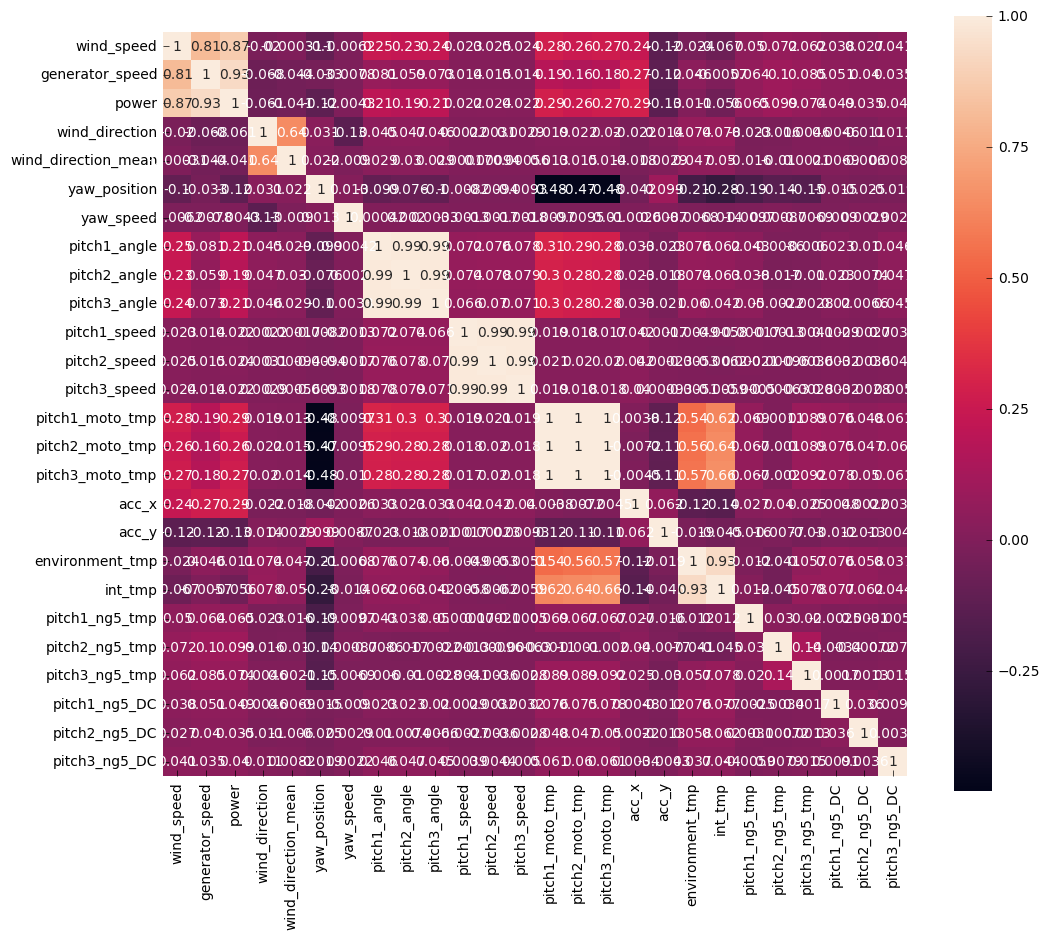

In [52]:
ax = plt.subplots( figsize =( 12 , 10 ) )
sns.heatmap(train_X.corr(), vmax=1.0, square=True, annot=True)

<a id='Modeling'></a>
## 2. Modeling

** Test and select the model features **

In [53]:
clf_log = LogisticRegression()
clf_log = clf_log.fit(train_X,train_y)
score_log = clf_log.score(train_X,train_y)
print('Training Data Accuracy:',score_log)

Training Data Accuracy: 0.861608539935


In [54]:
print('Feature Importance:')

fea = pd.DataFrame(list(zip(train_X.columns, np.transpose(clf_log.coef_))), columns=['feature','weight'])
fea['abs'] = abs(fea['weight'])
fea.sort_values(by='abs', ascending=False)

Feature Importance:


,feature,weight,abs
8,pitch2_angle,[19.5870972374],[19.5870972374]
9,pitch3_angle,[-15.0782653589],[15.0782653589]
15,pitch3_moto_tmp,[10.7475634166],[10.7475634166]
13,pitch1_moto_tmp,[-7.34448925015],[7.34448925015]
2,power,[-6.87826625623],[6.87826625623]
18,environment_tmp,[-3.5623674142],[3.5623674142]
0,wind_speed,[3.01708573302],[3.01708573302]
14,pitch2_moto_tmp,[-2.34319090026],[2.34319090026]
7,pitch1_angle,[-2.20582409844],[2.20582409844]
1,generator_speed,[2.03348245112],[2.03348245112]


** 1. Logistic Regression **

In [55]:
model_log = LogisticRegression()
model_log = model_log.fit(train_X,train_y)
pred_y = model_log.predict(valid_X)
score_log, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

pred_y = model_log.predict(valid_21_X)
score_log_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print(msg)

Score:0.7416373207560835 
	accuracy:0.7289704043351396, 
	recall:0.7867902665121669, 
	precision:0.5929095354523227
	(('tn', 5349), ('fn', 920), ('tp', 3395), ('fp', 2331))


** 2. Perceptron**

In [56]:
model_prcp = Perceptron(
    class_weight='balanced'
    )
model_prcp = model_prcp.fit(train_X,train_y)
pred_y = model_prcp.predict(valid_X)
score_pctr, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

pred_y = model_prcp.predict(valid_21_X)
score_pctr_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print(msg)

Score:0.7277631928350715 
	accuracy:0.7005418924551896, 
	recall:0.8247972190034762, 
	precision:0.5565285379202501
	(('tn', 4844), ('fn', 756), ('tp', 3559), ('fp', 2836))


** 3. K Nearest Neighbours **

In [57]:
model_knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance'
    )
model_knn = model_knn.fit(train_X,train_y)
pred_y = model_knn.predict(valid_X)
score_knn, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

pred_y = model_knn.predict(valid_21_X)
score_knn_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print(msg)

Score:0.680226212461375 
	accuracy:0.6765318882867861, 
	recall:0.6933951332560835, 
	precision:0.5391962515768607
	(('tn', 5123), ('fn', 1323), ('tp', 2992), ('fp', 2557))


**4. Support Vector Machine**

In [58]:
model_svm = svm.SVC(
    class_weight='balanced'
    )
model_svm = model_svm.fit(train_X,train_y)
pred_y = model_svm.predict(valid_X)
score_svm, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

pred_y = model_svm.predict(valid_21_X)
score_svm_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print(msg)

Score:0.5945432448580533 
	accuracy:0.6748645268862026, 
	recall:0.3082271147161066, 
	precision:0.5924276169265034
	(('tn', 6765), ('fn', 2985), ('tp', 1330), ('fp', 915))


**5. Decision Tree**

In [60]:
model_tree = tree.DecisionTreeClassifier(
    #max_depth=3,\
    class_weight="balanced",\
    min_weight_fraction_leaf=0.01\
    )
model_tree = model_tree.fit(train_X,train_y)
pred_y = model_tree.predict(valid_X)
score_tree, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

pred_y = model_tree.predict(valid_21_X)
score_tree_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print(msg)

Score:0.6759394463354577 
	accuracy:0.6451021258857857, 
	recall:0.7858632676709154, 
	precision:0.5043129089827484
	(('tn', 4347), ('fn', 924), ('tp', 3391), ('fp', 3333))


***

集成算法的目标是：组合几个基学习器的预测，以此来提高单个模型的泛化性和健壮性
集成方法常分为两类：
- averging methods：平均法的原则是： 独立的构建几个学习器，然后平均他们的预测。通常，组合的学习器要比任何一个单个的学习器要好，因为它降低了方差。   其中的代表：bagging 方法，随即森林
- boosting methods：学习器依次构建，试图降低组合的学习器的偏差。                                                                                                                                           其中的代表：AdaBoost，Gradient Tree Boosting

**6. Bagging**

In [59]:
model_bag = BaggingClassifier(
    KNeighborsClassifier(
        n_neighbors=2,
        weights='distance'
        ),
    oob_score=True,
    max_samples=0.5,
    max_features=1.0
    )

model_bag = model_bag.fit(train_X,train_y)
pred_y = model_bag.predict(valid_X)
#score_bag = clf_bag.oob_score_
score_bag, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

pred_y = model_bag.predict(valid_21_X)
score_bag_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print(msg)

Score:0.6625933939262263 
	accuracy:0.669945810754481, 
	recall:0.6363847045191193, 
	precision:0.5346573208722741
	(('tn', 5290), ('fn', 1569), ('tp', 2746), ('fp', 2390))


**7. Random Forest**

In [61]:
model_rf = RandomForestClassifier(
    n_estimators=1000, \
    max_depth=None, \
    min_samples_split=10 \
    #class_weight="balanced", \
    #min_weight_fraction_leaf=0.02 \
    )
model_rf = model_rf.fit(train_X,train_y)
pred_y = model_rf.predict(valid_X)
score_rf, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

pred_y = model_rf.predict(valid_21_X)
score_rf_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print(msg)

Score:0.600598535872924 
	accuracy:0.6542726135889955, 
	recall:0.4092699884125145, 
	precision:0.5249702734839476
	(('tn', 6082), ('fn', 2549), ('tp', 1766), ('fp', 1598))


**8. Extremely Randomised Trees**

In [62]:
model_etrtree = ExtraTreesClassifier(
    max_features='auto',
    bootstrap=True,
    oob_score=True,
    n_estimators=1000,
    max_depth=None,
    min_samples_split=10
    #class_weight="balanced",
    #min_weight_fraction_leaf=0.02
    )
model_etrtree = model_etrtree.fit(train_X,train_y)
pred_y = model_etrtree.predict(valid_X)
score_ext, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

pred_y = model_etrtree.predict(valid_21_X)
score_ext_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print(msg)

Score:0.6560945949208188 
	accuracy:0.6770320967069612, 
	recall:0.581460023174971, 
	precision:0.548175660913262
	(('tn', 5612), ('fn', 1806), ('tp', 2509), ('fp', 2068))


**9. Gradient Boosting:**

In [63]:
import warnings
warnings.filterwarnings("ignore")

model_gb = GradientBoostingClassifier(
            #loss='exponential',
            n_estimators=1000,
            learning_rate=0.1,
            max_depth=3,
            subsample=0.5,
            random_state=0)
model_gb = model_gb.fit(train_X,train_y)
pred_y = model_gb.predict(valid_X)
score_gb, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

pred_y = model_gb.predict(valid_21_X)
score_gb_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print(msg)

Score:0.6598470240681731 
	accuracy:0.6967903293038766, 
	recall:0.5281575898030128, 
	precision:0.5873711340206186
	(('tn', 6079), ('fn', 2036), ('tp', 2279), ('fp', 1601))


**9. Ada Boost:**

In [64]:
model_ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1)
model_ada = model_ada.fit(train_X,train_y)
pred_y = model_ada.predict(valid_X)
score_ada, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

pred_y = model_ada.predict(valid_21_X)
score_ada_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print(msg)

Score:0.737457980277134 
	accuracy:0.7578157565652355, 
	recall:0.6648899188876014, 
	precision:0.6628927911275416
	(('tn', 6221), ('fn', 1446), ('tp', 2869), ('fp', 1459))


**10. eXtreme Gradient Boosting:**

In [65]:
model_xgb = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    subsample=0.5,
    learning_rate=0.1
    )
model_xgb = model_xgb.fit(train_X,train_y)
pred_y = model_xgb.predict(valid_X)
score_xgb, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

pred_y = model_xgb.predict(valid_21_X)
score_xgb_21, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print(msg)

Score:0.7300754846224411 
	accuracy:0.7503126302626094, 
	recall:0.6579374275782155, 
	precision:0.6514456172556219
	(('tn', 6161), ('fn', 1476), ('tp', 2839), ('fp', 1519))


***

### Ranking of models and features

In [66]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Gradient Boosting', 'Bagging', 
              'Decision Tree','XGBoost','ExtraTree','Perceptron','Ada Boost'],
    'Score': [score_svm, score_knn, score_log, score_rf, score_gb, score_bag,
              score_tree,score_xgb,score_ext,score_pctr,score_ada]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Logistic Regression,0.741637
10,Ada Boost,0.737458
7,XGBoost,0.730075
9,Perceptron,0.727763
1,KNN,0.680226
6,Decision Tree,0.675939
5,Bagging,0.662593
4,Gradient Boosting,0.659847
8,ExtraTree,0.656095
3,Random Forest,0.600599


In [ ]:
models_21 = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Gradient Boosting', 'Bagging', 
              'Decision Tree','XGBoost','ExtraTree','Perceptron','Ada Boost'],
    'Score': [score_svm_21, score_knn_21, score_log_21, score_rf_21, score_gb_21, score_bag_21,
              score_tree_21,score_xgb_21,score_ext_21,score_pctr_21,score_ada_21]})
models_21.sort_values(by='Score', ascending=False)

In [23]:
summary = pd.DataFrame(list(zip(train_X.columns, \
    np.transpose(model_log.coef_), \
    np.transpose(model_prcp.coef_), \
#    np.transpose(model_knn.feature_importances_), \
    np.transpose(model_tree.feature_importances_), \
    np.transpose(model_rf.feature_importances_), \
    np.transpose(model_etrtree.feature_importances_), \
    np.transpose(model_gb.feature_importances_), \
    np.transpose(model_ada.feature_importances_), \
    np.transpose(model_xgb.feature_importances_), \
#    np.transpose(model_svm.coef_), \
#    np.transpose(model_bag.feature_importances_), \
    )), columns=['Feature','LogisticRegression','Perceptron','Tree','RF','Extra','GB','Ada','Xtreme'])
  
summary['Median'] = summary.median(1)
summary.sort_values('Median', ascending=False)

,Feature,LogisticRegression,Perceptron,Tree,RF,Extra,GB,Ada,Xtreme,Median
18,environment_tmp,[-3.5623674142],[-28.7879304041],0.290878,0.168615,0.159396,0.157358,0.1925,0.171214,0.169914
2,power,[-6.87826625623],[-52.0530462992],0.295759,0.117892,0.097715,0.063414,0.1400,0.118690,0.118291
5,yaw_position,[-0.149125491565],[4.02025937977],0.130113,0.095602,0.080090,0.101563,0.1350,0.133697,0.115838
19,int_tmp,[1.7739763084],[14.6194337277],0.041305,0.101618,0.097853,0.116270,0.0725,0.096180,0.097016
9,pitch3_angle,[-15.0782653589],[-125.167957433],0.016564,0.064757,0.074231,0.058247,0.1000,0.091405,0.069494
14,pitch2_moto_tmp,[-2.34319090026],[-31.7358549943],0.085295,0.069611,0.062258,0.063527,0.0400,0.084584,0.066569
8,pitch2_angle,[19.5870972374],[150.991838116],0.078289,0.062665,0.066510,0.062214,0.0775,0.058663,0.064587
15,pitch3_moto_tmp,[10.7475634166],[87.8271032236],0.035419,0.067483,0.063210,0.063187,0.1100,0.054570,0.063198
7,pitch1_angle,[-2.20582409844],[-13.1879337114],0.003413,0.050639,0.067805,0.046135,0.0350,0.066849,0.048387
13,pitch1_moto_tmp,[-7.34448925015],[-51.950637171],0.007989,0.064304,0.059804,0.030575,0.0275,0.048431,0.039503


***
### Optimising one classifier in more detail:

In [29]:
clf_xgb = xgb.XGBClassifier(subsample=0.5)
param_grid = {'max_depth':[2,3,5,7,9],
              'learning_rate':[0.1,0.01],
              #'booster': ['gbtree', 'gblinear', 'dart'],
              'n_estimators': [100, 500,1000]
              }
gs = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, scoring='accuracy', cv=3)
gs = gs.fit(train_X,train_y)
print(gs.best_score_)
print(gs.best_params_)

0.676031850899
{'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01}


In [31]:
clf_xgb = xgb.XGBClassifier(subsample=0.5)
param_grid = {'max_depth':[2,3,5,7,9],
              'learning_rate':[0.1,0.01],
              'n_estimators': [100, 500,1000]
              }
gs = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, scoring='recall', cv=3)
gs = gs.fit(train_X,train_y)
print(gs.best_score_)
print(gs.best_params_)

0.717340322288
{'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.1}


In [32]:
clf_xgb = xgb.XGBClassifier(subsample=0.5)
param_grid = {'max_depth':[2,3,5,7,9],
              'learning_rate':[0.1,0.01],
              'n_estimators': [100, 500,1000]
              }
gs = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, scoring='precision', cv=3)
gs = gs.fit(train_X,train_y)
print(gs.best_score_)
print(gs.best_params_)

0.70157604967
{'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.01}


In [45]:
model_xgb = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.01,
    n_estimators=1000
    )
model_xgb = model_xgb.fit(train_X,train_y)
pred_y = model_xgb.predict(valid_X)
score_xgb, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

pd.DataFrame(list(zip(valid_X.columns, np.transpose(model_xgb.feature_importances_))) \
            ).sort_values(1, ascending=False)



Score:0.7627263180764774 
	accuracy:0.7828261775739892, 
	recall:0.6910776361529548, 
	precision:0.7009873060648801
	(('tn', 6408), ('fn', 1333), ('tp', 2982), ('fp', 1272))


,0,1
18,environment_tmp,0.198347
5,yaw_position,0.114082
2,power,0.113758
9,pitch3_angle,0.109058
19,int_tmp,0.095608
8,pitch2_angle,0.090909
0,wind_speed,0.060930
14,pitch2_moto_tmp,0.054124
7,pitch1_angle,0.049263
15,pitch3_moto_tmp,0.046184


In [44]:
scores = cross_val_score(clf_xgb, train_X,train_y, cv=5)
print(scores)
print("Mean score(train) = %.3f, Std deviation = %.3f"%(np.mean(scores),np.std(scores)))

[ 0.76677677  0.75773644  0.71783727  0.80815369  0.72735176]
Mean score(train) = 0.756, Std deviation = 0.032


In [43]:
score_ext_test= cross_val_score(clf_xgb, valid_X,valid_y, cv=5)
print(score_ext_test)
print("Mean score(validation) = %.3f, Std deviation = %.3f"%(np.mean(score_ext_test),np.std(score_ext_test)))

[ 0.62526053  0.74947895  0.8295123   0.99958316  0.94747812]
Mean score(validation) = 0.830, Std deviation = 0.135


### Stacking / Ensemble methods

In [67]:
clf_vote = VotingClassifier(
    estimators=[
        ('logistic', model_log),
        ('ada', model_ada),
        ('bag', model_bag),
        ('xgb', model_xgb),
        ('percep', model_prcp),
        ('knn', model_knn),
        ('svm', model_svm),
        ('extra', model_etrtree),
        ('gb', model_gb),
        ('RF', model_rf),
        ('tree', model_tree)
        ],
    weights=[2,2,2,2,2,1,1,1,1,1,1],
    voting='hard')

clf_vote = clf_vote.fit(train_X,train_y)
pred_y = clf_vote.predict(valid_X)
score_xgb, accuracy, precision, recall, cmt, msg=myscore(valid_y, pred_y)
print(msg)

Score:0.752934440179606 
	accuracy:0.7689870779491454, 
	recall:0.695712630359212, 
	precision:0.6730941704035874
	(('tn', 6222), ('fn', 1313), ('tp', 3002), ('fp', 1458))


In [72]:
pred_y = clf_vote.predict(valid_21_X)
score_xgb, accuracy, precision, recall, cmt, msg=myscore(valid_21_y, pred_y)
print(msg)

Score:0.6064670956231634 
	accuracy:0.9286120021384656, 
	recall:0.24102274863696183, 
	precision:0.3508003830893419
	(('tn', 164185), ('fn', 8074), ('tp', 2564), ('fp', 4745))


***

** Predict Test Data**

In [ ]:
pred_T = clf_vote.predict(test_X)
pred_T_df = pd.DataFrame(pred_T)

pred_T_df.value_counts()

In [ ]:
pred_T_result = pred_T_df[0]

In [ ]:
startTime=0
endTIme=0
search_start=True
search_end=False
abnormal_list=[]
test_timeidx=test_timeidx.astype(int)
for i,v in enumerate(pred_T_result):
    if (v==1) & (search_start):
        startTime = test_timeidx[i]
        search_end=True
        search_start=False
    if (v==0) & (search_end):
        endTIme=test_timeidx[i]
        search_start=True
        search_end=False
        abnormal_list.append((startTime,test_timeidx[i-1]))
len(abnormal_list)
abnormal_list[:10]

In [ ]:
output_ans=True
if(output_ans):
    with open('test1_08_results.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['startTime','endTime'])
        for row in abnormal_list:
            dummy = csv_out.writerow(row)

print('done')